# Compute the formation efficiency for all variations we explored

Split by stable mass transfer channel vs CE channel
and by BBH/BHNS/NSNS

In [1]:
import numpy as np
import os 
import sys
import pandas as pd
import h5py as h5
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib as mpl

# add run_data path to sys
sys.path.append('./run_data')
from definitions import sim_flags_dict

home_dir = os.path.expanduser("~") 
compas_v = "v02.46.01/"#v02.35.02/"
datar_root =  f"{home_dir}/ceph/CompasOutput/{compas_v}/"


## Read the potential DCO data 
this table includes all systems that become a DCO at any Z (i.e. more info than just the DCO data)

### and subdivide by DCO flavour


In [2]:
    
def get_merging_dcos(sim_name =  'NewWinds_RemFryer2012', prog_table_name = 'potential_DCO_progenitors_Allinfo.h5'):
    """Read in the potential DCO progenitor table and return the tables for BBH, BHNS and NSNS mergers

    Args:
        sim_name (str, optional): which simulation to load Default 'NewWinds_RemFryer2012'.
        prog_table_name (str, optional): 'potential_DCO_progenitors_Allinfo.h5'.

    Returns:
        BBH_progenitors, BHNS_progenitors, NSNS_progenitors: pandas tables containing the progenitors of BBH, BHNS and NSNS mergers
    """
    ####################################
    # Take the base potential DCO progenitor table
    if os.path.isfile(datar_root+ f'/{sim_name}/'+prog_table_name):
        potential_DCO_progenitors = pd.read_hdf(datar_root + f'{sim_name}/' + prog_table_name, key='All_DCO')
        print('Table exists, reading in... ' ) #potential_DCO_progenitors.info()
    else:
        print('error, table doesnt exist, you should make it using "DataManipulation.ipynb" first')

    potential_DCO_progenitors.reset_index(drop=True, inplace=True)

    # Also make tables that contain only the actual BBH, BHNS and NSNS mergers
    def DCO_merger_bool(table, flavor = 'BBH'):
        """return the DCO merger bool for a given flavor

        Args:
            pandas table: containing all potential DCOs (incl. things that don't become DCO at specific Z)
            flavor (str, optional): BBH, BHNS, or NSNS 
        """
        BBH_bool = np.logical_and(table['Stellar_Type(1)'] == 14,table['Stellar_Type(2)'] == 14)
        BHNS_bool = np.logical_or(np.logical_and(table['Stellar_Type(1)'] == 13,table['Stellar_Type(2)'] == 14),
                                np.logical_and(table['Stellar_Type(1)'] == 14,table['Stellar_Type(2)'] == 13) )
        NSNS_bool = np.logical_and(table['Stellar_Type(1)'] == 13,table['Stellar_Type(2)'] == 13)
        if flavor == 'BBH':
            return np.logical_and(BBH_bool,table['Merges_Hubble_Time'] == True)
        elif flavor == 'BHNS':  
            return np.logical_and(BHNS_bool,table['Merges_Hubble_Time'] == True)
        elif flavor == 'NSNS':
            return np.logical_and(NSNS_bool,table['Merges_Hubble_Time'] == True)

    # make the tables for every flavour
    merging_BBH_bool  = DCO_merger_bool(potential_DCO_progenitors, flavor = 'BBH')
    BBH_progenitors  = potential_DCO_progenitors[merging_BBH_bool]

    merging_BHNS_bool  = DCO_merger_bool(potential_DCO_progenitors, flavor = 'BHNS')
    BHNS_progenitors = potential_DCO_progenitors[merging_BHNS_bool]

    merging_NSNS_bool  = DCO_merger_bool(potential_DCO_progenitors, flavor = 'NSNS')
    NSNS_progenitors = potential_DCO_progenitors[merging_NSNS_bool]

    return [BBH_progenitors, BHNS_progenitors, NSNS_progenitors]





# Plot the formation efficiency for each flavour

OldWinds_RemFryer2012
Table exists, reading in... 
BBH
BHNS
NSNS
OldWinds_RemMullerMandel
Table exists, reading in... 
BBH
BHNS
NSNS
OldWinds_RemFryer2012_noBHkick
Table exists, reading in... 
BBH
BHNS
NSNS
OldWinds_RemFryer2012_noNSBHkick
Table exists, reading in... 
BBH
BHNS
NSNS
OldWinds_RemFryer2012_noMSwinds
Table exists, reading in... 
BBH
BHNS
NSNS
OldWinds_RemFryer2012_noWRwinds
Table exists, reading in... 
BBH
BHNS
NSNS
OldWinds_RemFryer2012_NOwinds
Table exists, reading in... 
BBH
BHNS
NSNS
NewWinds_RemFryer2012
Table exists, reading in... 
BBH
BHNS
NSNS
NewWinds_RemMullerMandel
Table exists, reading in... 
BBH
BHNS
NSNS
NewWinds_RemFryer2012_noBHkick
Table exists, reading in... 
BBH
BHNS
NSNS
NewWinds_RemFryer2012_noNSBHkick
Table exists, reading in... 
BBH
BHNS
NSNS


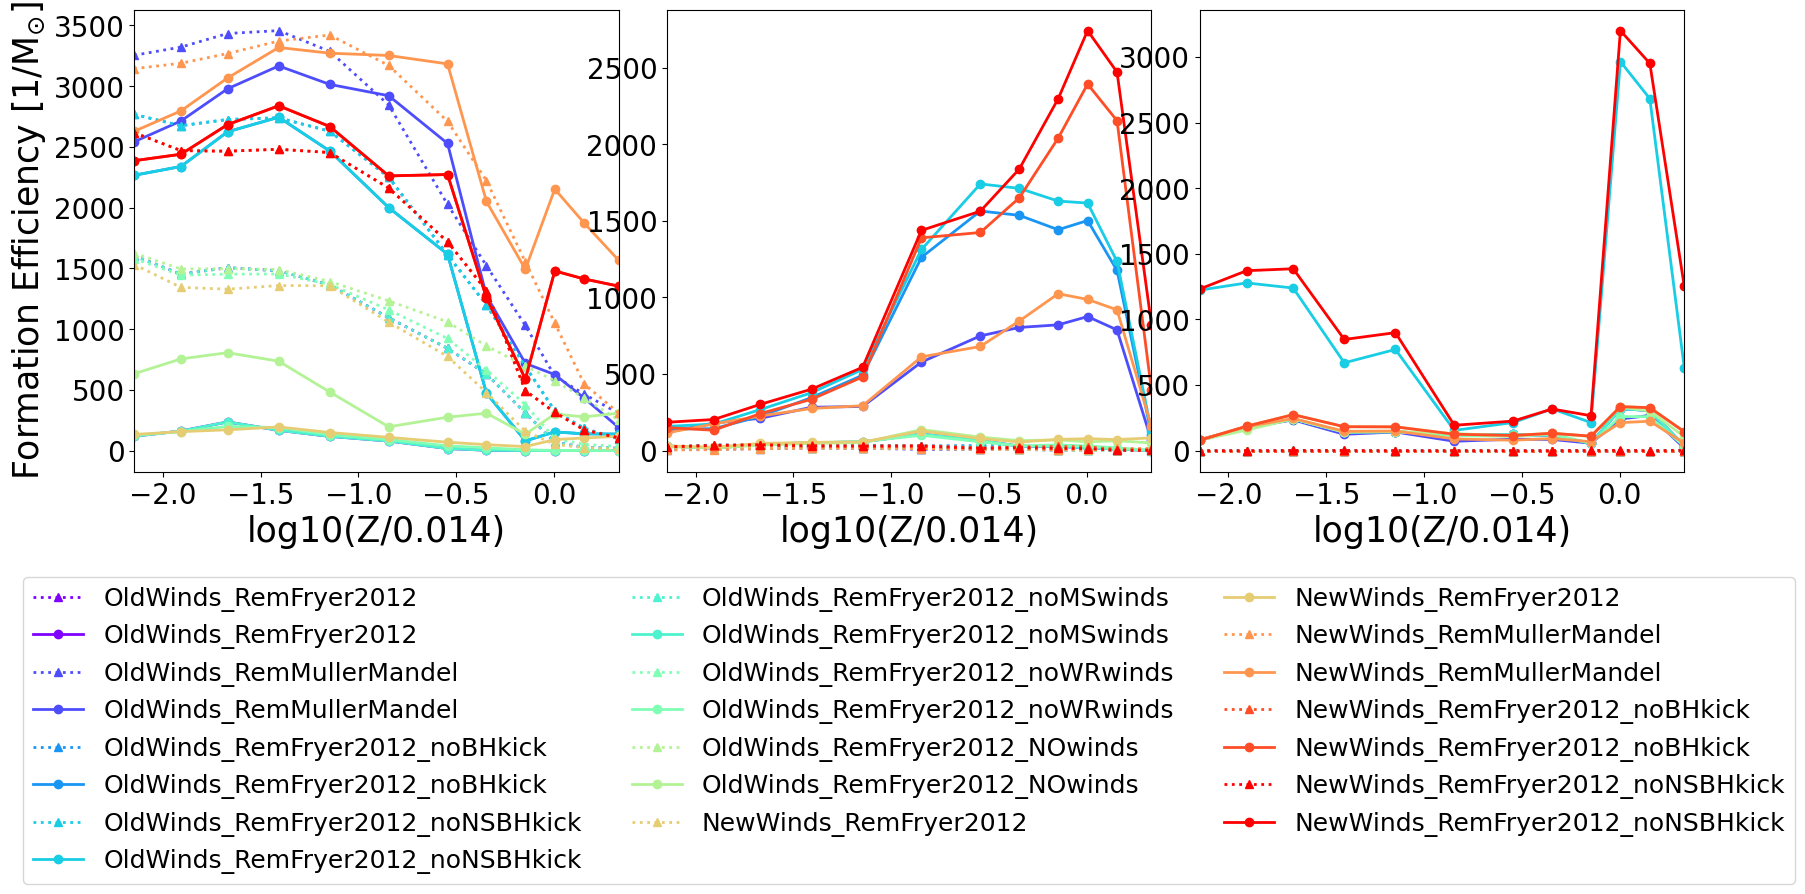

In [3]:
###########################################
# Create a figure
fig = plt.figure(figsize=(20, 6))

# Create a GridSpec with 1 row and 3 columns
gs      = GridSpec(1, 3, figure=fig)
axes    = [fig.add_subplot(gs[0, i]) for i in range(3)] # Create 3 subplots on a line

# List of panda tables of DCO mergers
DCO_flavors         = ["BBH", "BHNS", "NSNS"]

# get a list of colors
cmap = mpl.colormaps['rainbow']
colors = cmap(np.linspace(0, 1, len(sim_flags_dict.keys())) )


#########################
# loop over all simulations
for s, sim_name in enumerate(sim_flags_dict.keys()):
    print(sim_name)
        
    merging_DCO_tables  = get_merging_dcos(sim_name =  sim_name, prog_table_name = 'potential_DCO_progenitors_Allinfo.h5')

    #########################
    # Loop over the axes and DCO flavors
    for ax, table, flavor in zip(axes, merging_DCO_tables, DCO_flavors):
        print(flavor)

        # Group by metallicity
        grouped_byZ = table.groupby('Metallicity@ZAMS(1)')

        # Get all Z values and group lengths
        Z_values = np.array([Z for Z, group in grouped_byZ])

       # count the number of systems in each group for all, CE and stable channel
        All_group_lengths       = [len(group) for Z, group in grouped_byZ]
        stable_group_lengths    = [len(group[group['CE_Event_Counter'] == 0]) for Z, group in grouped_byZ]
        CE_group_lengths        = [len(group[group['CE_Event_Counter'] > 0]) for Z, group in grouped_byZ]

        # Plot the number of DCO mergers as a function of metallicity
        ax.plot(np.log10(Z_values/0.014), stable_group_lengths, label = sim_name, lw = 2, ls = ':', marker = '^', color = colors[s])
        ax.plot(np.log10(Z_values/0.014), CE_group_lengths, label = sim_name, lw = 2, ls = '-', marker = 'o', color = colors[s])

        #####
        # plotvalues
        ax.set_xlim(np.log10(1e-4/0.014),np.log10(0.03/0.014))
        ax.set_xlabel('log10(Z/0.014)', fontsize = 25)
        # ax.set_ylim(1e-9,5e-4)
        ax.tick_params(axis='both', which='major', labelsize=20)     # increase  tick labels
        ax.tick_params(axis='both', which='minor', labelsize=20)

#########################
# plotvalues
fig.subplots_adjust(hspace=0.25, wspace=0.1)
axes[0].set_ylabel("Formation Efficiency [1/$\mathrm{M_{\odot}}$]", fontsize =25)

axes[1].legend(bbox_to_anchor=(0.5, -0.2), loc='upper center', fontsize = 18, ncols = 3)

# plt.savefig(f'../plots/{compas_v}/Yield_variations.pdf', bbox_inches='tight')
plt.show()


In [ ]:
# Checking the min and max values of the initial mass

# import re
# masses1 = []
# with open('run_data/BSE_grid_mass_sep_kick.txt', 'r') as f:
#     for line in f:
#         match = re.search(r'--initial-mass-1 (\d+\.\d+)', line)
#         if match:
#             masses1.append(float(match.group(1)))
# print(masses1)
# print(min(masses1), max(masses1))
# 

In [36]:
import pandas


# NewWinds_RemFryer2012
h5_data = h5.File(f'{datar_root}/OldWinds_RemFryer2012/logZ-1.52/COMPAS_Output.h5', 'r')
# h5_data = h5.File(f'{home_dir}/ceph/CompasOutput/v03.01.02/NewWinds_RemFryer2012/logZ-4.0/batch_79/COMPAS_Output/COMPAS_Output.h5', 'r')

print(h5_data['BSE_System_Parameters'].keys())

m1 = h5_data['BSE_System_Parameters']['Mass@ZAMS(1)'][()]
print(min(m1), max(m1) )



m2 = h5_data['BSE_System_Parameters']['Mass@ZAMS(2)'][()]
print(min(m2), max(m2) )

run_details = h5_data['Run_Details']

# --random-seed 0 --initial-mass-1 6.339622373744429 --initial-mass-2 4.664862002817223 --semi-major-axis 19.143363410506385 --kick-magnitude-random-1 0.3489500342670595 --kick-phi-1 1.6863737455912653 --kick-theta-1 1.7113103925707782 --kick-mean-anomaly-1 0.4193232442378341 --kick-magnitude-random-2 0.14744499940366373 --kick-phi-2 2.2559523686889227 --kick-theta-2 0.2094033075619413 --kick-mean-anomaly-2 2.616134696056703

# Read the HDF5 datasets as pandas dataframes
SYS = pd.DataFrame()
# chosen to allow for rerunning of systems and other interesting parameters
sys_keys = ['SEED', 'Mass@ZAMS(1)', 'Mass@ZAMS(2)', 'SemiMajorAxis@ZAMS', 'SN_Kick_Magnitude_Random_Number(1)', 'SN_Kick_Phi(1)', 'SN_Kick_Theta(1)', 'SN_Kick_Mean_Anomaly(1)', 'SN_Kick_Magnitude_Random_Number(2)', 'SN_Kick_Phi(2)', 'SN_Kick_Theta(2)', 'SN_Kick_Mean_Anomaly(2)']

for key in sys_keys:
    # You cant directly apply the mask to the HDF5 dataset, so you have to read it first
    read_data = h5_data['BSE_System_Parameters'][key][()]
    SYS[key] = read_data


problematic_seeds = SYS['SEED'][SYS['Mass@ZAMS(1)']< 5. ]
print(len(problematic_seeds) )
print(np.sort(problematic_seeds) )

display(SYS[SYS['SEED'] == 11] )

# --random-seed 0 --initial-mass-1 6.339622373744429 --initial-mass-2 4.664862002817223 --semi-major-axis 19.143363410506385 --kick-magnitude-random-1 0.3489500342670595 --kick-phi-1 1.6863737455912653 --kick-theta-1 1.7113103925707782 --kick-mean-anomaly-1 0.4193232442378341 --kick-magnitude-random-2 0.14744499940366373 --kick-phi-2 2.2559523686889227 --kick-theta-2 0.2094033075619413 --kick-mean-anomaly-2 2.616134696056703


<KeysViewHDF5 ['Applied_Kick_Magnitude(1)', 'Applied_Kick_Magnitude(2)', 'CE_Alpha', 'CE_Event_Counter', 'CH_on_MS(1)', 'CH_on_MS(2)', 'Drawn_Kick_Magnitude(1)', 'Drawn_Kick_Magnitude(2)', 'Eccentricity@ZAMS', 'Equilibrated_At_Birth', 'Error', 'Evolution_Status', 'Immediate_RLOF>CE', 'LBV_Factor', 'Mass@ZAMS(1)', 'Mass@ZAMS(2)', 'Merger', 'Merger_At_Birth', 'Metallicity@ZAMS(1)', 'Metallicity@ZAMS(2)', 'Omega@ZAMS(1)', 'Omega@ZAMS(2)', 'Optimistic_CE', 'Record_Type', 'SEED', 'SN_Kick_Magnitude_Random_Number(1)', 'SN_Kick_Magnitude_Random_Number(2)', 'SN_Kick_Mean_Anomaly(1)', 'SN_Kick_Mean_Anomaly(2)', 'SN_Kick_Phi(1)', 'SN_Kick_Phi(2)', 'SN_Kick_Theta(1)', 'SN_Kick_Theta(2)', 'SemiMajorAxis@ZAMS', 'Sigma_Kick_CCSN_BH', 'Sigma_Kick_CCSN_NS', 'Sigma_Kick_ECSN', 'Sigma_Kick_USSN', 'Stellar_Type(1)', 'Stellar_Type(2)', 'Stellar_Type@ZAMS(1)', 'Stellar_Type@ZAMS(2)', 'SystemicSpeed', 'Unbound', 'WR_Factor']>
2.5695858942213294 149.97943259134644
0.10000646940162342 148.48299503722262
28679

,SEED,Mass@ZAMS(1),Mass@ZAMS(2),SemiMajorAxis@ZAMS,SN_Kick_Magnitude_Random_Number(1),SN_Kick_Phi(1),SN_Kick_Theta(1),SN_Kick_Mean_Anomaly(1),SN_Kick_Magnitude_Random_Number(2),SN_Kick_Phi(2),SN_Kick_Theta(2),SN_Kick_Mean_Anomaly(2)
900011,11,9.206945,2.672216,0.567021,0.246313,4.150651,1.215015,3.432085,0.567668,4.551316,1.659859,1.585601


In [40]:
import pandas

# NewWinds_RemFryer2012
h5_data = h5.File(f'{datar_root}/OldWinds_RemFryer2012/logZ-4.0/COMPAS_Output.h5', 'r')
# h5_data = h5.File(f'{home_dir}/ceph/CompasOutput/v03.01.02/NewWinds_RemFryer2012/logZ-4.0/batch_79/COMPAS_Output/COMPAS_Output.h5', 'r')

print(h5_data['BSE_System_Parameters'].keys())

m1 = h5_data['BSE_System_Parameters']['Mass@ZAMS(1)'][()]
print(min(m1), max(m1) )

m2 = h5_data['BSE_System_Parameters']['Mass@ZAMS(2)'][()]
print(min(m2), max(m2) )

run_details = h5_data['Run_Details']

# --random-seed 0 --initial-mass-1 6.339622373744429 --initial-mass-2 4.664862002817223 --semi-major-axis 19.143363410506385 --kick-magnitude-random-1 0.3489500342670595 --kick-phi-1 1.6863737455912653 --kick-theta-1 1.7113103925707782 --kick-mean-anomaly-1 0.4193232442378341 --kick-magnitude-random-2 0.14744499940366373 --kick-phi-2 2.2559523686889227 --kick-theta-2 0.2094033075619413 --kick-mean-anomaly-2 2.616134696056703

# Read the HDF5 datasets as pandas dataframes
SYS = pd.DataFrame()
# chosen to allow for rerunning of systems and other interesting parameters
sys_keys = ['SEED', 'Mass@ZAMS(1)', 'Mass@ZAMS(2)', 'SemiMajorAxis@ZAMS', 'SN_Kick_Magnitude_Random_Number(1)', 'SN_Kick_Phi(1)', 'SN_Kick_Theta(1)', 'SN_Kick_Mean_Anomaly(1)', 'SN_Kick_Magnitude_Random_Number(2)', 'SN_Kick_Phi(2)', 'SN_Kick_Theta(2)', 'SN_Kick_Mean_Anomaly(2)']

for key in sys_keys:
    # You cant directly apply the mask to the HDF5 dataset, so you have to read it first
    read_data = h5_data['BSE_System_Parameters'][key][()]
    SYS[key] = read_data


problematic_seeds = SYS['SEED'][SYS['Mass@ZAMS(1)']< 5. ]
print(len(problematic_seeds) )
print(np.sort(problematic_seeds) )

display(SYS[SYS['SEED'] == 89] )

# --random-seed 0 --initial-mass-1 6.339622373744429 --initial-mass-2 4.664862002817223 --semi-major-axis 19.143363410506385 --kick-magnitude-random-1 0.3489500342670595 --kick-phi-1 1.6863737455912653 --kick-theta-1 1.7113103925707782 --kick-mean-anomaly-1 0.4193232442378341 --kick-magnitude-random-2 0.14744499940366373 --kick-phi-2 2.2559523686889227 --kick-theta-2 0.2094033075619413 --kick-mean-anomaly-2 2.616134696056703


<KeysViewHDF5 ['Applied_Kick_Magnitude(1)', 'Applied_Kick_Magnitude(2)', 'CE_Alpha', 'CE_Event_Counter', 'CH_on_MS(1)', 'CH_on_MS(2)', 'Drawn_Kick_Magnitude(1)', 'Drawn_Kick_Magnitude(2)', 'Eccentricity@ZAMS', 'Equilibrated_At_Birth', 'Error', 'Evolution_Status', 'Immediate_RLOF>CE', 'LBV_Factor', 'Mass@ZAMS(1)', 'Mass@ZAMS(2)', 'Merger', 'Merger_At_Birth', 'Metallicity@ZAMS(1)', 'Metallicity@ZAMS(2)', 'Omega@ZAMS(1)', 'Omega@ZAMS(2)', 'Optimistic_CE', 'Record_Type', 'SEED', 'SN_Kick_Magnitude_Random_Number(1)', 'SN_Kick_Magnitude_Random_Number(2)', 'SN_Kick_Mean_Anomaly(1)', 'SN_Kick_Mean_Anomaly(2)', 'SN_Kick_Phi(1)', 'SN_Kick_Phi(2)', 'SN_Kick_Theta(1)', 'SN_Kick_Theta(2)', 'SemiMajorAxis@ZAMS', 'Sigma_Kick_CCSN_BH', 'Sigma_Kick_CCSN_NS', 'Sigma_Kick_ECSN', 'Sigma_Kick_USSN', 'Stellar_Type(1)', 'Stellar_Type(2)', 'Stellar_Type@ZAMS(1)', 'Stellar_Type@ZAMS(2)', 'SystemicSpeed', 'Unbound', 'WR_Factor']>
2.582946286509198 149.97943259134644
0.10000646940162342 148.48299503722262
14856


,SEED,Mass@ZAMS(1),Mass@ZAMS(2),SemiMajorAxis@ZAMS,SN_Kick_Magnitude_Random_Number(1),SN_Kick_Phi(1),SN_Kick_Theta(1),SN_Kick_Mean_Anomaly(1),SN_Kick_Magnitude_Random_Number(2),SN_Kick_Phi(2),SN_Kick_Theta(2),SN_Kick_Mean_Anomaly(2)
900089,89,4.584766,4.584766,0.016417,0.641956,6.010346,2.608104,4.412026,0.162373,4.374451,2.440541,3.504661


In [29]:
run_details.keys()


grid_keys = ['grid', 'grid-Derivation', 'grid-lines-to-process', 'grid-lines-to-process-Derivation', 'grid-start-line', 'grid-start-line-Derivation']
for key in grid_keys:
    print(run_details[key][()])



[b"'/mnt/home/lvanson/ceph/CompasOutput/v02.46.01/OldWinds_RemFryer2012/BSE_grid_mass_sep_kick.txt'"
 b"'/mnt/home/lvanson/ceph/CompasOutput/v02.46.01/OldWinds_RemFryer2012/BSE_grid_mass_sep_kick.txt'"
 b"'/mnt/home/lvanson/ceph/CompasOutput/v02.46.01/OldWinds_RemFryer2012/BSE_grid_mass_sep_kick.txt'"
 b"'/mnt/home/lvanson/ceph/CompasOutput/v02.46.01/OldWinds_RemFryer2012/BSE_grid_mass_sep_kick.txt'"
 b"'/mnt/home/lvanson/ceph/CompasOutput/v02.46.01/OldWinds_RemFryer2012/BSE_grid_mass_sep_kick.txt'"
 b"'/mnt/home/lvanson/ceph/CompasOutput/v02.46.01/OldWinds_RemFryer2012/BSE_grid_mass_sep_kick.txt'"
 b"'/mnt/home/lvanson/ceph/CompasOutput/v02.46.01/OldWinds_RemFryer2012/BSE_grid_mass_sep_kick.txt'"
 b"'/mnt/home/lvanson/ceph/CompasOutput/v02.46.01/OldWinds_RemFryer2012/BSE_grid_mass_sep_kick.txt'"
 b"'/mnt/home/lvanson/ceph/CompasOutput/v02.46.01/OldWinds_RemFryer2012/BSE_grid_mass_sep_kick.txt'"
 b"'/mnt/home/lvanson/ceph/CompasOutput/v02.46.01/OldWinds_RemFryer2012/BSE_grid_mass_sep_k

,SEED,Mass@ZAMS(1),Mass@ZAMS(2),SemiMajorAxis@ZAMS,SN_Kick_Magnitude_Random_Number(1),SN_Kick_Phi(1),SN_Kick_Theta(1),SN_Kick_Mean_Anomaly(1),SN_Kick_Magnitude_Random_Number(2),SN_Kick_Phi(2),SN_Kick_Theta(2),SN_Kick_Mean_Anomaly(2)
0,900000,5.010389,0.145423,0.785201,0.919227,2.887009,0.644848,2.964127,0.759735,3.276615,1.148524,3.891084
1,900001,5.457398,4.227925,0.078015,0.748574,6.276804,1.459578,1.820269,0.702945,5.941694,2.866523,0.747708
2,900002,84.497915,9.781453,8.994675,0.328929,3.584261,0.984828,1.702069,0.786651,2.289247,2.178157,5.369956
3,900003,6.238068,6.097866,38.449857,0.001084,4.276088,2.150123,2.398577,0.705318,1.698578,0.453856,5.460980
4,900004,6.799026,6.275186,18.245649,0.942515,3.050036,2.143425,0.587611,0.324511,4.067270,0.648746,1.467281
...,...,...,...,...,...,...,...,...,...,...,...,...
999995,824995,7.400773,5.776794,0.072194,0.439415,1.733653,1.960378,5.187659,0.515726,3.017013,1.369478,4.099182
999996,824996,16.841010,9.404920,1.377289,0.544333,4.810567,2.505330,3.130468,0.257015,3.912487,1.596579,2.247902
999997,824997,7.445875,6.926761,3.658874,0.074497,1.973657,1.564929,1.557826,0.732510,3.897798,1.990507,1.603770
999998,824998,12.583879,8.716210,6.117774,0.197567,1.673324,1.146233,2.200217,0.412955,3.986069,1.597859,3.856711


(array([104016., 388892., 168451.,  91359.,  56627.,  37941.,  26944.,
         20135.]),
 array([ 2.5   ,  5.3125,  8.125 , 10.9375, 13.75  , 16.5625, 19.375 ,
        22.1875, 25.    ]),
 <BarContainer object of 8 artists>)

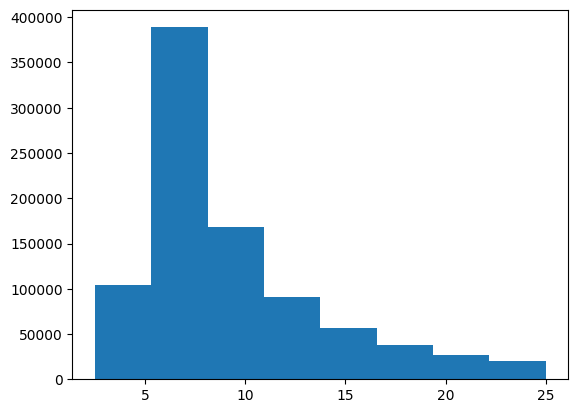

In [18]:
display(SYS)

plt.hist(SYS['Mass@ZAMS(1)'] , bins = np.linspace(2.5, 25, 9))

In [6]:
h5_data = h5.File(f'{datar_root}/NewWinds_RemFryer2012/COMPAS_Output_combinedZ.h5', 'r')

print(h5_data['BSE_System_Parameters'].keys())

m1 = h5_data['BSE_System_Parameters']['Mass@ZAMS(1)'][()]
print(min(m1), max(m1) )

m2 = h5_data['BSE_System_Parameters']['Mass@ZAMS(2)'][()]
print(min(m2), max(m2) )

run_details = h5_data['Run_Details']


# initial_mass_keys = ['initial-mass', 'initial-mass-1', 'initial-mass-1-Derivation', 'initial-mass-2', 'initial-mass-2-Derivation', 'initial-mass-Derivation', 'initial-mass-function', 'initial-mass-function-Derivation', 'initial-mass-max', 'initial-mass-max-Derivation', 'initial-mass-min', 'initial-mass-min-Derivation', 'initial-mass-power', 'initial-mass-power-Derivation']
initial_mass_keys = ['initial-mass', 'initial-mass-1',  'initial-mass-2', 'initial-mass-function', 'initial-mass-max',  'initial-mass-min']

for key in initial_mass_keys:
    print(key, run_details[key][0])



<KeysViewHDF5 ['Applied_Kick_Magnitude(1)', 'Applied_Kick_Magnitude(2)', 'CE_Alpha', 'CE_Event_Counter', 'CH_on_MS(1)', 'CH_on_MS(2)', 'Drawn_Kick_Magnitude(1)', 'Drawn_Kick_Magnitude(2)', 'Eccentricity@ZAMS', 'Equilibrated_At_Birth', 'Error', 'Evolution_Status', 'Immediate_RLOF>CE', 'LBV_Factor', 'Mass@ZAMS(1)', 'Mass@ZAMS(2)', 'Merger', 'Merger_At_Birth', 'Metallicity@ZAMS(1)', 'Metallicity@ZAMS(2)', 'Omega@ZAMS(1)', 'Omega@ZAMS(2)', 'Optimistic_CE', 'Record_Type', 'SEED', 'SN_Kick_Magnitude_Random_Number(1)', 'SN_Kick_Magnitude_Random_Number(2)', 'SN_Kick_Mean_Anomaly(1)', 'SN_Kick_Mean_Anomaly(2)', 'SN_Kick_Phi(1)', 'SN_Kick_Phi(2)', 'SN_Kick_Theta(1)', 'SN_Kick_Theta(2)', 'SemiMajorAxis@ZAMS', 'Sigma_Kick_CCSN_BH', 'Sigma_Kick_CCSN_NS', 'Sigma_Kick_ECSN', 'Sigma_Kick_USSN', 'Stellar_Type(1)', 'Stellar_Type(2)', 'Stellar_Type@ZAMS(1)', 'Stellar_Type@ZAMS(2)', 'SystemicSpeed', 'Unbound', 'WR_Factor']>
2.5695858942213294 149.97943259134644
0.10000646940162342 148.48299503722262
initi

# Compute the 'total mass evolved per Z'

In [ ]:
def totalMassEvolvedPerZ(pathCOMPASh5=None, Mlower_COMPAS=None, Mupper_COMPAS=None, binaryFraction=1, \
                         x1=0.01, x2=0.08, x3=0.5, x4=200., a1=-0.3, a2=-1.3, a3=-2.3, C1=1., Mmax=200):
    """_summary_

    Args:
        pathCOMPASh5 (_type_, optional): _description_. Defaults to None.
        Mlower_COMPAS (float, optional): _description_. Defaults to None.
        Mupper_COMPAS (float, optional): _description_. Defaults to None.
        binaryFraction (int, optional): _description_. Defaults to 1.
        x2 (float, optional): _description_. Defaults to 0.08.
        x3 (float, optional): _description_. Defaults to 0.5.
        x4 (_type_, optional): _description_. Defaults to 200..
        a1 (float, optional): _description_. Defaults to -0.3.
        a2 (float, optional): _description_. Defaults to -1.3.
        a3 (float, optional): _description_. Defaults to -2.3.
        C1 (_type_, optional): _description_. Defaults to 1..
        Mmax (int, optional): _description_. Defaults to 200.

    Raises:
        TypeError: _description_
        TypeError: _description_
        TypeError: _description_

    Returns:
        _type_: _description_
    """

    #the default values assume a Kroupa IMF for M1
    if pathCOMPASh5 is None:
        raise TypeError("\n Need to give path to directory COMPASOutput.h5")
    if Mlower_COMPAS is None:
        raise TypeError("\n Need to give lower limit M1 of pythonSubmit")
    if Mupper_COMPAS is None:
        raise TypeError("\n Need to give upper limit M1 of pythonSubmit")
    

    M1, M2 = createSampleUniverse(binaryFraction=binaryFraction, x1=x1, x2=x2, x3=x3, x4=x4, \
                                  a1=a1, a2=a2, a3=a3, C1=C1, Mmax=Mmax)

    totalMassInStarFormation = np.sum(M1) + np.sum(M2)

    #Now mask M1 and M2 to see what lies in the range of COMPAS
    maskM1 = (M1>=Mlower_COMPAS) & (M1<=Mupper_COMPAS)
    maskBinaries = (M2!=0)
    mask = maskM1 & maskBinaries

    totalMassEvolvedCOMPAS = np.sum(M1[mask]) + np.sum(M2[mask])

    #multiplication fraction
    fraction = totalMassEvolvedCOMPAS/float(totalMassInStarFormation)

    #so we need to muliply the mass evolved per metallicity times (1/fraction)
    #to know the total mass evolved per metallicity
    data = h5.File(pathCOMPASh5, 'r')
    boolWeighted = 'mixture_weight' in data['BSE_Double_Compact_Objects'].keys()
    # boolWeighted = retrieveBoolWeightedSimulation(pathCOMPASh5) # //floor


    if boolWeighted: # samples are weighted we can't just add M1 + M2 from simulation # //floor
        NbinariesEvolvedPerZ = retrieveNbinariesEvolvedPerZ(pathCOMPASh5)     # Nbinaries simulated per Z //floor
        AverageMassPerBinaryCOMPAS = totalMassEvolvedCOMPAS / len(M1[mask])   # average mass of a binary in COMPAS simulation  //floor
        MassEvolvedPerZ = AverageMassPerBinaryCOMPAS * NbinariesEvolvedPerZ  # //floor    
        print('weighted samples :-D')    # //floor

    else: # tradutional simulation
        # MassEvolvedPerZ = retrieveMassEvolvedPerZ(pathCOMPASh5)
        # path = os.path.join(path, 'COMPASOutput.h5') #path+'COMPASOutput.h5'
        f = h5.File(pathCOMPASh5, 'r') # open in read-
        allSystems = f['systems']
        metals = (allSystems['Metallicity1'])[...]
        m1s = (allSystems['mass1'])[...]
        m2s = (allSystems['mass2'])[...]
        total = []
        for Z in np.unique(metals):
            mask = metals == Z
            total.append(np.sum(m1s[mask]) + np.sum(m2s[mask]))
        MassEvolvedPerZ  = np.array(total)

    multiplicationFactor = 1./fraction

    totalMassEvolvedPerMetallicity = (MassEvolvedPerZ)/(fraction)

    return multiplicationFactor, totalMassEvolvedPerMetallicity

In [ ]:

def CDFbrokenPowerLaw(x, x1, x2, x3, x4, a1, a2, a3, C1):
    yvalues = np.zeros(len(x))
    
    C2    = float(C1 * (x2**(a1-a2)))
    C3    = float(C2 * (x3**(a2-a3)))
    
    N1 = float(((1./(a1+1)) * C1 * (x2**(a1+1))) - ((1./(a1+1)) * C1 * (x1**(a1+1))))
    N2 = float(((1./(a2+1)) * C2 * (x3**(a2+1))) - ((1./(a2+1)) * C2 * (x2**(a2+1))))
    N3 = float(((1./(a3+1)) * C3 * (x4**(a3+1))) - ((1./(a3+1)) * C3 * (x3**(a3+1))))
    
    bottom = N1+N2+N3
    
    mask1 = (x>=x1) & (x<x2)
    top1 = (((1./(a1+1)) * C1 * (x[mask1]**(a1+1)) - (1./(a1+1)) * C1 * (x1**(a1+1))))
    yvalues[mask1] = top1/bottom
    
    #calculate values of the x values that are x2<=x<x3
    mask2 = (x>=x2) & (x<x3)
    top2 =  N1 + (((1./(a2+1)) * C2 * (x[mask2]**(a2+1)) - (1./(a2+1)) * C2 * (x2**(a2+1))))
    yvalues[mask2] = top2/bottom
    
    #calculate values of the x values that are x3<=x<=x4
    mask3 = (x>=x3) & (x<=x4)
    top3 =  N1 + N2 + (((1./(a3+1)) * C3 * (x[mask3]**(a3+1)) - (1./(a3+1)) * C3 * (x3**(a3+1))))
    yvalues[mask3] = top3/bottom
    return yvalues


def invertCDFbrokenPowerLaw(CDF, x1, x2, x3, x4, a1, a2, a3, C1):
    #I specifically do floats against python rounding when dividing
    
    #The constants needed
    C2    = float(C1 * (x2**(a1-a2)))
    C3    = float(C2 * (x3**(a2-a3)))
    
    N1 = float(((1./(a1+1)) * C1 * (x2**(a1+1))) - ((1./(a1+1)) * C1 * (x1**(a1+1))))
    N2 = float(((1./(a2+1)) * C2 * (x3**(a2+1))) - ((1./(a2+1)) * C2 * (x2**(a2+1))))
    N3 = float(((1./(a3+1)) * C3 * (x4**(a3+1))) - ((1./(a3+1)) * C3 * (x3**(a3+1))))
    
    bottom = N1+N2+N3
    
    CDFx2 = CDFbrokenPowerLaw(np.array([x2,x2]), x1, x2, x3, x4, a1, a2, a3, C1)[0]
    CDFx3 = CDFbrokenPowerLaw(np.array([x3,x3]), x1, x2, x3, x4, a1, a2, a3, C1)[0]

    
    xvalues = np.zeros(len(CDF))
    
    mask1 = (CDF < CDFx2)
    xvalues[mask1] =  (((CDF[mask1]*(N1+N2+N3))  + \
                      ( (1./(a1+1))*C1*(x1**(a1+1))))/((1./(a1+1))*C1))**(1./(a1+1))
    
    mask2 = (CDFx2<= CDF) & (CDF < CDFx3)
    xvalues[mask2] = ((((CDF[mask2]*(N1+N2+N3))-(N1))  + \
                      ( (1./(a2+1))*C2*(x2**(a2+1))))/((1./(a2+1))*C2))**(1./(a2+1))
    
    mask3 = (CDFx3<= CDF) 
    xvalues[mask3] = ((((CDF[mask3]*(N1+N2+N3))-(N1+N2))  + \
                      ((1./(a3+1))*C3*(x3**(a3+1))))/((1./(a3+1))*C3))**(1./(a3+1))
    
    return xvalues


def createSampleUniverse(binaryFraction=1., x1=0.01, x2=0.08, x3=0.5, x4=200, a1=-0.3, \
                            a2=-1.3, a3=-2.3, C1=1, sampleSize=2000000, Mmin=0.01, Mmax=200):
    
    binaryFraction = binaryFraction

    #Given the defined three-part broken powerlaw,
    #We can sample a subset by using Mmin, Mmax.
    #We convert it to the respective values between
    #0-1 and only sample uniformly between those (woohoo :D)
    #Mmin and Mmax have to be between x1 and x4
    CDFmin = CDFbrokenPowerLaw(np.array([Mmin]), x1, x2, x3, x4, a1, a2, a3, C1)
    CDFmax = CDFbrokenPowerLaw(np.array([Mmax]), x1, x2, x3, x4, a1, a2, a3, C1)
    
    #All the random drawing that we need
    drawM1         = np.random.uniform(CDFmin,CDFmax,sampleSize)
    drawBinary     = np.random.uniform(0,1,sampleSize)
    drawM2         = np.random.uniform(0,1,sampleSize)

    #All the arrays we want to fill
    M1 = np.zeros(sampleSize)
    M2 = np.zeros(sampleSize)

    #Define the IMF broken powerlaw and calculate masses from inverted CDF


    M1 = invertCDFbrokenPowerLaw(drawM1, x1, x2, x3, x4, a1, a2, a3, C1)

    #Binary fraction is easier, since we draw between 0-1, every draw with 
    #value above binary fraction = single star and every value below is binary
    #for a single star we set M2=0 Msun.
    #Note that we assume that the binary Fraction is mass indepent
    #Future work to implenet Max Moe ps and qs options
    maskBinary = drawBinary < binaryFraction  #booleans

    #again for the secondary we assume the mass ratio distribution to be flat across
    #the whole parameter range so then the drawM2 (if it is in a binary) 
    #just becomes the mass fraction.

    M2[maskBinary] = np.multiply(drawM2[maskBinary],M1[maskBinary])
    #all the ones outside the mask remain zero
    return M1, M2


def inverseCDF(C, CDF, index, xmin, xmax):
    #CDF sincle powerlaw
    a =  (1./(index + 1)) * C * CDF**(index+1)
    b =  (1./(index + 1)) * C * xmin**(index+1)
    c =  (1./(index + 1)) * C * xmax**(index+1)
    top    = ((CDF * (c-b))+b)*(index + 1)
    bottom = C
    return (top/bottom)**(1./(index+1))


def retrieveNbinariesEvolvedPerZ(path):  # /floor added this function to replace function above. 
    # returns array with N of binaries simulated in each COMPAS run. 

    # path = os.path.join(path, 'COMPASOutput.h5') #path+'COMPASOutput.h5'
    f = h5.File(path, 'r') # open in read-only
    allSystems = f['systems']
    metals = (allSystems['Metallicity1'])[...]


    m1s = (allSystems['mass1'])[...] # /floor
    total = []
    for Z in np.unique(metals):
        mask = metals == Z
        Nbinaries = len(m1s[mask])
        total.append(Nbinaries)
    return np.array(total)






# functions that I think are not needed:

In [ ]:

def threePartBrokenPowerLaw(x, x1=0.01, x2=0.08, x3=0.5, x4=200, a1=-0.3, \
                            a2=-1.3, a3=-2.3, C1=1):
    #Not that everything outside the range x1<x4 is set to zero
    yvalues = np.zeros(len(x))
    
    #calculate values of the x values that are x1<=x<x2
    mask1 = (x>=x1) & (x<x2)
    yvalues[mask1] = C1 * (x[mask1]**a1)
    
    #calculate values of the x values that are x2<=x<x3
    mask2 = (x>=x2) & (x<x3)
    C2    = C1 * (x2**(a1-a2))
    yvalues[mask2] = C2 * (x[mask2]**a2)
    
    #calculate values of the x values that are x3<=x<=x4
    mask3 = (x>=x3) & (x<=x4)
    C3    = C1 * (x2**(a1-a2)) * (x3**(a2-a3))
    yvalues[mask3] = C3 * (x[mask3]**a3)
    
    return yvalues

def recalculateTrueSolarMassEvolved(self, Mlower, Mupper, binaryFraction):
    #Possibility to test assumptions of True solar mass evolved
    self.Mlower              = Mlower
    self.Mupper              = Mupper
    self.binaryFraction      = binaryFraction
    _, self.totalMassEvolvedPerZ =\
    totalMassEvolvedPerZ(pathCOMPASh5=self.path , Mlower=self.Mlower, \
                                Mupper=self.Mupper, binaryFraction=self.binaryFraction)

def retrieveBoolWeightedSimulation(path): # //floor 
    """returns True if the simulation used weighted samples (not one) """
    # path = os.path.join(path, 'COMPASOutput.h5') #path+'COMPASOutput.h5'
    f = h5.File(path, 'r') # open in read-only
    allSystems = f['systems']
    metals = (allSystems['Metallicity1'])[...]
    weights = allSystems['weight'][...].squeeze()

    for Z in [np.unique(metals)[0]]:
        mask = metals == Z
        # print(weights)
        # print(mask)
        boolWeighted = not(all( [v == 1 for v in weights[mask[...].squeeze()]] ))

    # boolWeighted = not(all( [v == 1 for v in weights] )) # //floor check if this takes too much time to evaluate, then just do DCO and 1 metallicity
    return boolWeighted
